In [2]:
import json
import jsonlines
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from sklearn.metrics import silhouette_score

from importlib import reload
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster

from scipy.sparse import csr_matrix

# Variables Setup

In [3]:
dataset_name = "hBreast"
models = ["BayXenSmooth", "Leiden", "Louvain", "K-Means", "K-Means_No_Spatial", "Hierarchical", "Hierarchical_No_Spatial", "BayesSpace"]
resolutions = [0.75]
spot_sizes = [100, 75, 50]
K_values = [17]

In [4]:
# BayXenSmooth Hyperparameters
BayXenSmooth_PCs = [3, 5, 10, 25]
BayesSpace_PCs = [3, 5, 10, 15, 25]
neighborhood_sizes = [1,2,3,4,5]
sample_for_assignment = False
concentration_amp = 1.0
spatial_norms = [0.05, 0.1]
aggs = ["sum", "mean", "weighted"]

# Load Data

In [5]:
# Path to your .gz file
file_path = f'data/{dataset_name}/transcripts.csv.gz'

# Read the gzipped CSV file into a DataFrame
df_transcripts = pd.read_csv(file_path, compression='gzip')

# drop cells without ids
df_transcripts = df_transcripts[df_transcripts["cell_id"] != -1]

# drop blanks and controls
df_transcripts = df_transcripts[~df_transcripts["feature_name"].str.startswith('BLANK_') & ~df_transcripts["feature_name"].str.startswith('NegControl')]

KeyboardInterrupt: 

# Other Metric Implementations

- Variation Index (TODO) If we want to compare competing methods clustering with our clustering.


In [ ]:
def morans_i_cluster_similarity(clustering, locations, clusters):
    print("Starting Moran's I Calculation.")
    moran_clusters = ad.AnnData(locations)
    sc.pp.neighbors(moran_clusters, n_pcs=0, n_neighbors=100)
    print("Neighbors calculated.")

    cluster_labels = clusters.values
    # Calculate Moran's I for the binary presence of each cluster
    unique_clusters = np.unique(cluster_labels)
    morans_i_results = {}
    for cluster in unique_clusters:
        cluster_indicator = (cluster_labels == cluster).astype(int)
        morans_i = sc.metrics.morans_i(moran_clusters, vals=cluster_indicator)
        morans_i_results[cluster] = morans_i

    print("Done!")
    return np.mean(list(morans_i_results.values()))

In [ ]:
def gearys_c_cluster_similarity(clustering, locations, clusters):
    print("Starting Gearys's C Calculation.")
    gearys_clusters = ad.AnnData(locations)
    sc.pp.neighbors(gearys_clusters, n_pcs=0, n_neighbors=100)
    print("Neighbors calculated.")

    cluster_labels = clusters.values
    # Calculate Gearys C for the binary presence of each cluster
    unique_clusters = np.unique(cluster_labels)
    gearys_c_results = {}
    for cluster in unique_clusters:
        cluster_indicator = (cluster_labels == cluster).astype(int)
        gearys_c = sc.metrics.gearys_c(gearys_clusters, vals=cluster_indicator)
        gearys_c_results[cluster] = gearys_c

    print("Done!")
    return np.mean(list(gearys_c_results.values()))

In [ ]:
def save_results(results, dataset_name, method, metric_name, spot_size, init_method=None, n_pcs=None, resolution=None, K=17, neighborhood_size=1, sample_for_assignment=True, concentration_amp=1.0, gamma=1.0):
    if resolution is not None:
        directory = f"results/{dataset_name}/{method}/{resolution}/{metric_name}/{spot_size}"
    elif method == "BayXenSmooth":
        directory = f"results/{dataset_name}/{method}/clusters/PCA/{n_pcs}/INIT={init_method}/NEIGHBORSIZE={neighborhood_size}/NUMCLUSTERS={K}/SPATIALINIT={True if spatial_norm > 0.0 else False}/SAMPLEFORASSIGNMENT={sample_for_assignment}/SPATIALNORM={spatial_norm}/SPATIALPRIORMULT={concentration_amp}/SPOTSIZE={spot_size}/AGG={agg}"
    elif method == "mclust":
        directory = f"results/{dataset_name}/{method}/{n_pcs}/{K}/{metric_name}/{spot_size}"
    elif method == "BayesSpace":
        directory = f"results/{dataset_name}/{method}/{n_pcs}/{K}/{metric_name}/{init_method}/{spot_size}/{gamma}"
    else:
        directory = f"results/{dataset_name}/{method}/{K}/{metric_name}/{spot_size}"
    print(directory)
    if not os.path.exists(directory):
        os.makedirs(directory)
    with jsonlines.open(f"{directory}/{metric_name}.jsonl", mode='w') as writer:
        try:
            for key, value in results.items():
                writer.write({key: value})
        except AttributeError: # b/c it's not a dictionary so .items() fails
            writer.write(results)

# Calculate the Silhouette Score (and other metrics of note.)

In [ ]:
# for spot_size in spot_sizes:
#     clustering = XeniumCluster(data=df_transcripts, dataset_name=dataset_name)
#     clustering.set_spot_size(spot_size)
#     clustering.create_spot_data(third_dim=False, save_data=True)
#     locations = clustering.xenium_spot_data.obs[["row", "col"]]
#     for model in models:
#         for K in K_values:
#             if model in ["Leiden", "Louvain"]:
#                 for resolution in resolutions:
#                     clusters = pd.read_csv(f"results/{dataset_name}/{model}/{resolution}/clusters/{spot_size}/clusters_RES={resolution}.csv")[f"{model} cluster"]
#                     save_results(silhouette_score(locations, clusters), dataset_name, model, "silhouette_score", spot_size, resolution=resolution)
#                     save_results(morans_i_cluster_similarity(clustering, locations, clusters), dataset_name, model, "morans_i", spot_size, resolution=resolution)
#                     save_results(gearys_c_cluster_similarity(clustering, locations, clusters), dataset_name, model, "gearys_c", spot_size, resolution=resolution)
#             elif model == "BayXenSmooth":
#                 min_expressions_per_spot = 10
#                 clustering.xenium_spot_data = clustering.xenium_spot_data[clustering.xenium_spot_data.X.sum(axis=1) > min_expressions_per_spot]
#                 for neighborhood_size in neighborhood_sizes:
#                     clusters = pd.read_csv(f"results/{dataset_name}/{model}/clusters/PCA/{BayXenSmooth_PCs}/KMEANSINIT=True/NEIGHBORSIZE={neighborhood_size}/NUMCLUSTERS={K}/SPATIALINIT=True/SAMPLEFORASSIGNMENT={sample_for_assignment}/SPATIALNORM={spatial_norm}/SPATIALPRIORMULT={concentration_amp}/SPOTSIZE={spot_size}/AGG={agg}/clusters_K={K}.csv")[f"{model} cluster"]
#                     save_results(silhouette_score(locations, clusters), dataset_name, model, "silhouette_score", spot_size, K=K)
#                     save_results(morans_i_cluster_similarity(clustering, locations, clusters), dataset_name, model, "morans_i", spot_size, K=K, sample_for_assignment=sample_for_assignment)
#                     save_results(gearys_c_cluster_similarity(clustering, locations, clusters), dataset_name, model, "gearys_c", spot_size, K=K, sample_for_assignment=sample_for_assignment)
#             else:
#                 clusters = pd.read_csv(f"results/{dataset_name}/{model}/{K}/clusters/{spot_size}/clusters_K={K}.csv")[f"{model} cluster"]
#                 save_results(silhouette_score(locations, clusters), dataset_name, model, "silhouette_score", spot_size, K=K)
#                 save_results(morans_i_cluster_similarity(clustering, locations, clusters), dataset_name, model, "morans_i", spot_size, K=K)
#                 save_results(gearys_c_cluster_similarity(clustering, locations, clusters), dataset_name, model, "gearys_c", spot_size, K=K)

# Marker Gene Autocorrelation

In [ ]:
MARKER_GENES = ["BANK1", "CEACAM6", "FASN", "FGL2", "IL7R", "KRT6B", "POSTN", "TCIM"]

In [ ]:
def gene_morans_i(clustering, moran_clusters, clusters, num_neighbors=100, marker_genes=MARKER_GENES):

    # Create a binary adjacency matrix indicating if points are in the same cluster
    cluster_labels = clusters.values
    same_cluster = (cluster_labels[:, None] == cluster_labels).astype(int)
    print(moran_clusters.obsp["connectivities"].shape, same_cluster.shape)
    moran_clusters.obsp["adjacency"] = moran_clusters.obsp["connectivities"].multiply(csr_matrix(same_cluster))
    print("Connectivities formed.")

    # Calculate Moran's I for the genes
    morans_i = sc.metrics.morans_i(moran_clusters.obsp["adjacency"], vals=clustering.xenium_spot_data.X.T)

    morans_i_dict = dict(zip(clustering.xenium_spot_data.var.index, morans_i))

    for gene in marker_genes:
        print(num_neighbors, gene, morans_i_dict[gene])

    return morans_i_dict

NameError: name 'MARKER_GENES' is not defined

In [ ]:
def gene_gearys_c(clustering, gearys_clusters, clusters, num_neighbors=100):

    # Create a binary adjacency matrix indicating if points are in the same cluster
    cluster_labels = clusters.values
    same_cluster = (cluster_labels[:, None] == cluster_labels).astype(int)
    gearys_clusters.obsp["adjacency"] = gearys_clusters.obsp["connectivities"].multiply(csr_matrix(same_cluster))
    print("Connectivities formed.")

    # Calculate Geary's C for the genes
    gearys_c= sc.metrics.gearys_c(gearys_clusters.obsp["adjacency"], vals=clustering.xenium_spot_data.X.T)

    gearys_c_dict = dict(zip(clustering.xenium_spot_data.var.index, gearys_c))

    return gearys_c_dict

In [ ]:
models = ["BayesSpace"]
spot_sizes = [50]
spatial_norms = [0.0]
concentration_amps = [1.0, 2.0, 3.0, 4.0, 5.0, 7.5, 10.0]
num_neighboring_spots = [100]
custom_inits = ["Leiden", "K-Means", "mclust"]
BayesSpace_inits = ["mclust", "kmeans"]

In [ ]:
for spot_size in spot_sizes:
    clustering = XeniumCluster(data=df_transcripts, dataset_name=dataset_name)
    clustering.set_spot_size(spot_size)
    clustering.create_spot_data(third_dim=False, save_data=True)
    locations = clustering.xenium_spot_data.obs[["row", "col"]]
    moran_clusters = ad.AnnData(locations)
    gearys_clusters = ad.AnnData(locations)
    for model in models:
        print(model)
        for neighboring_spots in num_neighboring_spots:

            moran_clusters = ad.AnnData(locations)
            sc.pp.neighbors(moran_clusters, n_pcs=0, n_neighbors=neighboring_spots)
            print("Neighbors calculated.")

            gearys_clusters = ad.AnnData(locations)
            sc.pp.neighbors(gearys_clusters, n_pcs=0, n_neighbors=neighboring_spots)
            print("Neighbors calculated.")

            for K in K_values:
                if model in ["Leiden", "Louvain"]:
                    for resolution in resolutions:
                        clusters = pd.read_csv(f"results/{dataset_name}/{model}/{resolution}/clusters/{spot_size}/clusters_RES={resolution}.csv")[f"{model} cluster"]
                        save_results(gene_morans_i(clustering, moran_clusters, clusters, num_neighbors=neighboring_spots), dataset_name, model, "morans_i_by_gene", spot_size, resolution=resolution)
                        # save_results(gene_gearys_c(clustering, gearys_clusters, clusters), dataset_name, model, "gearys_c_by_gene", spot_size, resolution=resolution)
                elif model == "BayXenSmooth":
                    for n_pcs in BayXenSmooth_PCs:
                        for neighborhood_size in neighborhood_sizes:
                            for sample_for_assignment in [False, True]:
                                for agg in aggs:
                                    for spatial_norm in spatial_norms:
                                        for concentration_amp in concentration_amps:
                                            for custom_init in custom_inits:
                                                try:
                                                    clusters = pd.read_csv(f"results/{dataset_name}/{model}/clusters/PCA/{n_pcs}/INIT={custom_init}/NEIGHBORSIZE={neighborhood_size}/NUMCLUSTERS={K}/SPATIALINIT={False}/SAMPLEFORASSIGNMENT={sample_for_assignment}/SPATIALNORM={spatial_norm}/SPATIALPRIORMULT={concentration_amp}/SPOTSIZE={spot_size}/AGG={agg}/clusters_K={K}.csv")[f"{model} cluster"]
                                                    save_results(gene_morans_i(clustering, moran_clusters, clusters, num_neighbors=neighboring_spots), dataset_name, model, "morans_i_by_gene", spot_size, K=K, neighborhood_size=neighborhood_size, sample_for_assignment=sample_for_assignment, concentration_amp=concentration_amp, n_pcs=n_pcs, init_method=custom_init)
                                                    # save_results(gene_gearys_c(clustering, gearys_clustersgearys_clusters, clusters), dataset_name, model, "gearys_c_by_gene", spot_size, K=K, neighborhood_size=neighborhood_size, sample_for_assignment=sample_for_assignment, concentration_amp=concentration_amp, n_pcs=n_pcs)
                                                    print(f"BayXenSmooth with run {spot_size}um, {neighborhood_size} neighbors, sample={sample_for_assignment}, spatial_norm={spatial_norm}, concentraion_amp={concentration_amp}, n_pcs={n_pcs} and agg={agg} done!")
                                                except FileNotFoundError:
                                                    continue
                elif model == "BayesSpace":
                    for gamma in np.linspace(1, 3, 9):
                        for num_pcs in BayesSpace_PCs:
                            for custom_init in BayesSpace_inits:
                                try:
                                    gamma_str = f"{gamma:.2f}"
                                    clusters = pd.read_csv(f"results/{dataset_name}/{model}/{num_pcs}/{K}/clusters/{custom_init}/{spot_size}/clusters_K={K}_gamma={gamma_str}.csv")[f"{model} cluster"]
                                    save_results(gene_morans_i(clustering, moran_clusters, clusters, num_neighbors=neighboring_spots), dataset_name, model, "morans_i_by_gene", spot_size, init_method=custom_init, K=K, n_pcs=num_pcs, gamma=gamma)
                                    # save_results(gene_gearys_c(clustering, gearys_clusters, clusters), dataset_name, model, "gearys_c_by_gene", spot_size, K=K)
                                except FileNotFoundError:
                                    continue
                elif model == "mclust":
                    for num_pcs in BayesSpace_PCs:
                        try:
                            clusters = pd.read_csv(f"results/{dataset_name}/{model}/{num_pcs}/{K}/clusters/{spot_size}/clusters_K={K}.csv")[f"{model} cluster"]
                            save_results(gene_morans_i(clustering, moran_clusters, clusters, num_neighbors=neighboring_spots), dataset_name, model, "morans_i_by_gene", spot_size, K=K, n_pcs=num_pcs)
                            # save_results(gene_gearys_c(clustering, gearys_clusters, clusters), dataset_name, model, "gearys_c_by_gene", spot_size, K=K)
                        except FileNotFoundError:
                            continue
                else:
                    clusters = pd.read_csv(f"results/{dataset_name}/{model}/{K}/clusters/{spot_size}/clusters_K={K}.csv")[f"{model} cluster"]
                    save_results(gene_morans_i(clustering, moran_clusters, clusters, num_neighbors=neighboring_spots), dataset_name, model, "morans_i_by_gene", spot_size, K=K)
                    # save_results(gene_gearys_c(clustering, gearys_clusters, clusters), dataset_name, model, "gearys_c_by_gene", spot_size, K=K)

/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


BayesSpace
Neighbors calculated.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.49285262147183373
100 CEACAM6 0.4034828676498193
100 FASN 1.1484535556667932
100 FGL2 0.42007016180862644
100 IL7R 0.4984894619830656
100 KRT6B 0.30230621567224125
100 POSTN 0.4549144856232951
100 TCIM 0.44682659834139665
results/hBreast/BayesSpace/3/17/morans_i_by_gene/mclust/50/1.0
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8104063328181602
100 CEACAM6 0.40569311686232096
100 FASN 1.154031822282157
100 FGL2 0.48291203682723455
100 IL7R 0.6882647086103676
100 KRT6B 0.3553185438933171
100 POSTN 0.48692551880909335
100 TCIM 0.49454989671609206
results/hBreast/BayesSpace/3/17/morans_i_by_gene/kmeans/50/1.0
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 1.4256485385932562
100 CEACAM6 0.3988174982305732
100 FASN 1.153715249467882
100 FGL2 0.5702002332024274
100 IL7R 1.1677223850567024
100 KRT6B 0.2781771630759275
100 POSTN 0.47897675111203813
100 TCIM 0.5477588842268

# BayXenSmooth Best Moran's I

In [ ]:
import os
import json

# Define the directory where the results are stored
results_dir = "results/hBreast/BayXenSmooth"

# Loop through all subdirectories in the results directory
morans_i_dict = {}
for gene_name in MARKER_GENES:
    current_max_expression = 0
    for root, dirs, files in os.walk(results_dir):
        for file in files:
            # Check if the file is named morans_i_by_gene.json
            if file == "morans_i_by_gene.jsonl":
                # Construct the full path to the file
                file_path = os.path.join(root, file)
                # Open and read the file
                with open(file_path, 'r') as f:
                    # Load the JSON data
                    data = [line for line in jsonlines.Reader(f)]
                    # Print the data to verify it's been loaded
                    morans_i = [x for x in data if gene_name in x]
                    if morans_i[0][gene_name] > current_max_expression and "SPOTSIZE=50" in file_path:# and "K-Means" in file_path:
                        current_max_filepath = file_path
                        current_max_expression = morans_i[0][gene_name]
    morans_i_dict[gene_name] = current_max_expression, current_max_filepath

In [ ]:
morans_i_dict

{'BANK1': (1.3765650453755613,
  'results/hBreast/BayXenSmooth/clusters/PCA/3/INIT=Leiden/NEIGHBORSIZE=5/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=4.0/SPOTSIZE=50/AGG=mean/morans_i_by_gene.jsonl'),
 'CEACAM6': (0.41735854849646514,
  'results/hBreast/BayXenSmooth/clusters/PCA/3/INIT=mclust/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=3.0/SPOTSIZE=50/AGG=mean/morans_i_by_gene.jsonl'),
 'FASN': (1.2463172269044045,
  'results/hBreast/BayXenSmooth/clusters/PCA/10/INIT=mclust/NEIGHBORSIZE=5/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=2.0/SPOTSIZE=50/AGG=mean/morans_i_by_gene.jsonl'),
 'FGL2': (0.5308419497531766,
  'results/hBreast/BayXenSmooth/clusters/PCA/10/INIT=K-Means/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=7.5/SPOTSIZE=50/AGG=mean/morans_i_by_gene.jsonl'),
 'IL7R'

# Best Moran's I

In [ ]:
import os
import json

MARKER_GENES = ["BANK1", "CEACAM6", "FASN", "FGL2", "IL7R", "KRT6B", "POSTN", "TCIM"]

# Define the directory where the results are stored
results_dir = "results/hBreast"

# Loop through all subdirectories in the results directory
morans_i_dict = {}
for gene_name in MARKER_GENES:
    current_max_expression = 0
    for root, dirs, files in os.walk(results_dir):
        for file in files:
            # Check if the file is named morans_i_by_gene.json
            if file == "morans_i_by_gene.jsonl":
                # Construct the full path to the file
                file_path = os.path.join(root, file)
                # Open and read the file
                with open(file_path, 'r') as f:
                    # Load the JSON data
                    data = [line for line in jsonlines.Reader(f)]
                    # Print the data to verify it's been loaded
                    morans_i = [x for x in data if gene_name in x]
                    unused_runs = ["Leiden/2.0", "Leiden/1.5", "Louvain/2.0", "Louvain/1.5"]
                    if morans_i[0][gene_name] > current_max_expression and "50/" in file_path and not any(x in file_path for x in unused_runs):
                        current_max_filepath = file_path
                        current_max_expression = morans_i[0][gene_name]
    morans_i_dict[gene_name] = current_max_expression, current_max_filepath

In [ ]:
morans_i_dict

{'BANK1': (1.4659762123719298,
  'results/hBreast/BayesSpace/5/17/morans_i_by_gene/kmeans/50/1.0/morans_i_by_gene.jsonl'),
 'CEACAM6': (0.44061166528173595,
  'results/hBreast/Hierarchical/17/morans_i_by_gene/50/morans_i_by_gene.jsonl'),
 'FASN': (1.2764190262433492,
  'results/hBreast/mclust/5/17/morans_i_by_gene/50/morans_i_by_gene.jsonl'),
 'FGL2': (0.6541047360674477,
  'results/hBreast/K-Means/17/morans_i_by_gene/50/morans_i_by_gene.jsonl'),
 'IL7R': (1.2555361612748626,
  'results/hBreast/K-Means/17/morans_i_by_gene/50/morans_i_by_gene.jsonl'),
 'KRT6B': (0.9633136956155999,
  'results/hBreast/K-Means/17/morans_i_by_gene/50/morans_i_by_gene.jsonl'),
 'POSTN': (0.6150417644630521,
  'results/hBreast/Leiden/0.75/morans_i_by_gene/50/morans_i_by_gene.jsonl'),
 'TCIM': (0.8439597793911461,
  'results/hBreast/BayXenSmooth/clusters/PCA/3/INIT=Leiden/NEIGHBORSIZE=5/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=10.0/SPOTSIZE=50/AGG=mean/morans

# Specific Methods Comparison

In [ ]:
import os
import json

# Define the directory where the results are stored
# results_dirs = ["results/hBreast/BayXenSmooth", "results/hBreast/BayesSpace"]
results_dirs = ["results/hBreast/BayesSpace"]
results_dirs = ["results/hBreast/mclust"]

# Loop through all subdirectories in the results directory
morans_i_dict = {}
for gene_name in MARKER_GENES:
    current_max_expression = 0
    for dir in results_dirs:
        for root, dirs, files in os.walk(dir):
            for file in files:
                # Check if the file is named morans_i_by_gene.json
                if file == "morans_i_by_gene.jsonl":
                    # Construct the full path to the file
                    file_path = os.path.join(root, file)
                    # Open and read the file
                    with open(file_path, 'r') as f:
                        # Load the JSON data
                        data = [line for line in jsonlines.Reader(f)]
                        # Print the data to verify it's been loaded
                        morans_i = [x for x in data if gene_name in x]
                        unused_runs = ["Leiden/2.0", "Leiden/1.5", "Louvain/2.0", "Louvain/1.5"]
                        if morans_i[0][gene_name] > current_max_expression and "50/" in file_path and not any(x in file_path for x in unused_runs):
                            current_max_filepath = file_path
                            current_max_expression = morans_i[0][gene_name]
        morans_i_dict[gene_name] = current_max_expression, current_max_filepath

In [ ]:
morans_i_dict

{'BANK1': (1.2196548657566428,
  'results/hBreast/mclust/5/17/morans_i_by_gene/50/morans_i_by_gene.jsonl'),
 'CEACAM6': (0.42422911912896605,
  'results/hBreast/mclust/3/17/morans_i_by_gene/50/morans_i_by_gene.jsonl'),
 'FASN': (1.2764190262433492,
  'results/hBreast/mclust/5/17/morans_i_by_gene/50/morans_i_by_gene.jsonl'),
 'FGL2': (0.4852970956846807,
  'results/hBreast/mclust/5/17/morans_i_by_gene/50/morans_i_by_gene.jsonl'),
 'IL7R': (0.9695665363539054,
  'results/hBreast/mclust/10/17/morans_i_by_gene/50/morans_i_by_gene.jsonl'),
 'KRT6B': (0.7320552428683916,
  'results/hBreast/mclust/10/17/morans_i_by_gene/50/morans_i_by_gene.jsonl'),
 'POSTN': (0.5614955941096855,
  'results/hBreast/mclust/25/17/morans_i_by_gene/50/morans_i_by_gene.jsonl'),
 'TCIM': (0.8101239529657277,
  'results/hBreast/mclust/15/17/morans_i_by_gene/50/morans_i_by_gene.jsonl')}

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.


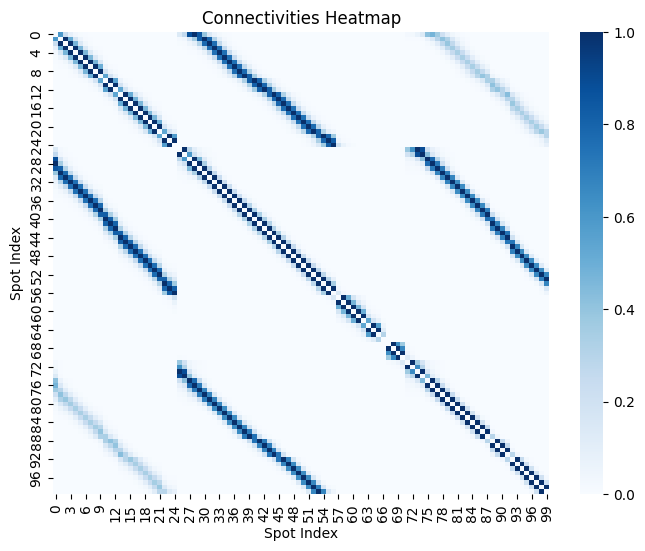

(23444, 23444) (23444, 23444)
Connectivities formed.


In [ ]:
spots_per_side = 100

print("Starting Moran's I Calculation.")
moran_clusters = ad.AnnData(locations)
sc.pp.neighbors(moran_clusters, n_pcs=0, n_neighbors=100)
print("Neighbors calculated.")

connectivities_submatrix = moran_clusters.obsp["connectivities"][:spots_per_side, :spots_per_side].A
# connectivities_submatrix = same_cluster[:spots_per_side, :spots_per_side]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(connectivities_submatrix, cmap='Blues')
plt.title('Connectivities Heatmap')
plt.xlabel('Spot Index')
plt.ylabel('Spot Index')
plt.show()

# Create a binary adjacency matrix indicating if points are in the same cluster
cluster_labels = clusters.values
same_cluster = (cluster_labels[:, None] == cluster_labels).astype(int)
print(moran_clusters.obsp["connectivities"].shape, same_cluster.shape)
moran_clusters.obsp["connectivities"] = moran_clusters.obsp["connectivities"].multiply(csr_matrix(same_cluster))
print("Connectivities formed.")

# Calculate Moran's I for the genes
morans_i = sc.metrics.morans_i(moran_clusters, vals=clustering.xenium_spot_data.X.T)

morans_i_dict = dict(zip(clustering.xenium_spot_data.var.index, morans_i))

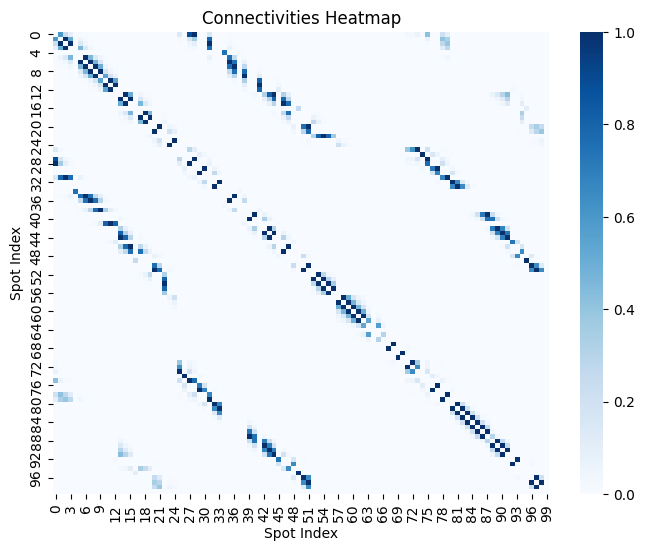

In [ ]:
# Extract the first 10x10 submatrix of the connectivities matrix
connectivities_submatrix = moran_clusters.obsp["connectivities"][:spots_per_side, :spots_per_side].A
# connectivities_submatrix = same_cluster[:spots_per_side, :spots_per_side]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(connectivities_submatrix, cmap='Blues')
plt.title('Connectivities Heatmap')
plt.xlabel('Spot Index')
plt.ylabel('Spot Index')
plt.show()

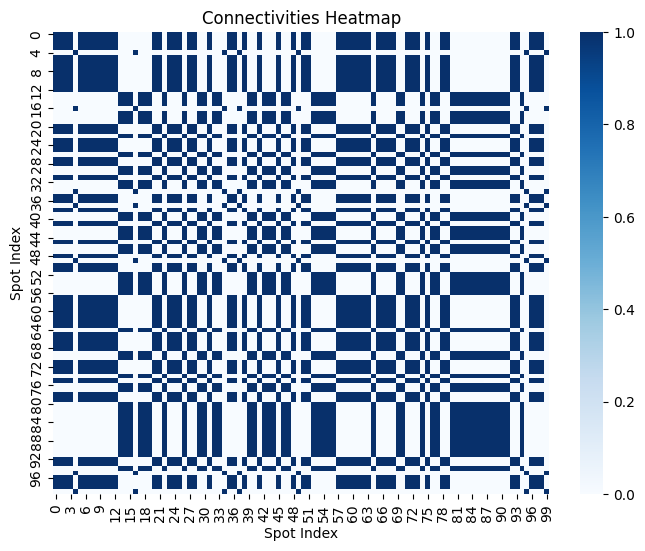

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

spots_per_side = 100

# Extract the first 10x10 submatrix of the connectivities matrix
# connectivities_submatrix = moran_clusters.obsp["connectivities"][:spots_per_side, :spots_per_side].A
connectivities_submatrix = same_cluster[:spots_per_side, :spots_per_side]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(connectivities_submatrix, cmap='Blues')
plt.title('Connectivities Heatmap')
plt.xlabel('Spot Index')
plt.ylabel('Spot Index')
plt.show()

# Sanity Check of Clusters and Moran's I Values

/tmp/ipykernel_120602/3024920468.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cluster_grid[rows, columns] = torch.tensor(clusters) + 1
/tmp/ipykernel_120602/3024920468.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', num_clusters + 1)


Text(0.5, 1.0, 'Prior Cluster Assignment with BayXenSmooth')

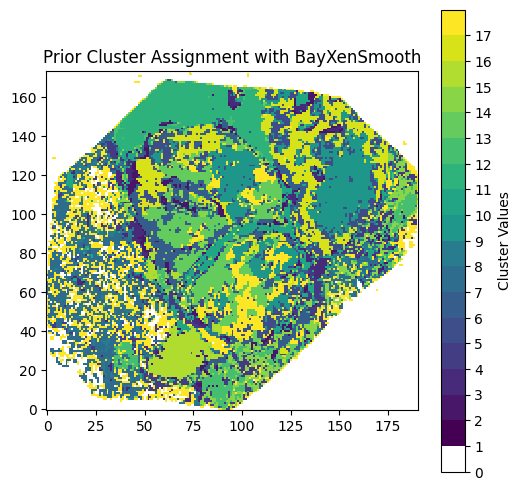

In [ ]:
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

num_clusters = K

rows = locations["row"].astype(int)
columns = locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

cluster_grid[rows, columns] = torch.tensor(clusters) + 1

colors = plt.cm.get_cmap('viridis', num_clusters + 1)

colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
colormap = ListedColormap(colormap_colors)

plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
plt.title('Prior Cluster Assignment with BayXenSmooth')

In [ ]:
import os
import numpy as np

# Define the directory to search
search_directory = 'results/hBreast/BayesSpace'

# List to store the paths of all .csv files
csv_files = []

# Walk through the directory
for root, dirs, files in os.walk(search_directory):
    for file in files:
        if file.endswith('.csv'):
            clusters = pd.read_csv(os.path.join(root, file))["BayesSpace cluster"]
            print(os.path.join(root, file), len(np.unique(clusters.values)))

results/hBreast/BayesSpace/25/17/clusters/kmeans/50/clusters_K=17_gamma=1.75.csv 17
results/hBreast/BayesSpace/25/17/clusters/kmeans/50/clusters_K=17_gamma=1.25.csv 17
results/hBreast/BayesSpace/25/17/clusters/kmeans/50/clusters_K=17_gamma=1.50.csv 17
results/hBreast/BayesSpace/25/17/clusters/kmeans/50/clusters_K=17_gamma=1.00.csv 17
results/hBreast/BayesSpace/15/17/clusters/mclust/50/clusters_K=17_gamma=3.00.csv 16
results/hBreast/BayesSpace/15/17/clusters/mclust/50/clusters_K=17_gamma=1.75.csv 16
results/hBreast/BayesSpace/15/17/clusters/mclust/50/clusters_K=17_gamma=2.25.csv 16
results/hBreast/BayesSpace/15/17/clusters/mclust/50/clusters_K=17_gamma=2.00.csv 16
results/hBreast/BayesSpace/15/17/clusters/mclust/50/clusters_K=17_gamma=1.25.csv 16
results/hBreast/BayesSpace/15/17/clusters/mclust/50/clusters_K=17_gamma=1.50.csv 16
results/hBreast/BayesSpace/15/17/clusters/mclust/50/clusters_K=17_gamma=2.75.csv 16
results/hBreast/BayesSpace/15/17/clusters/mclust/50/clusters_K=17_gamma=1.00